# Reducing uncertainty through measurement to improve design

Intro text ...

#### Setup

In [14]:
import os
import yaml
from tqdm.auto import tqdm
import numpy as np
from numpy import random
from scipy import stats
from scipy.stats import linregress

from functools import partial
from utils import get_Gurobi_WLS_env
from models import run_model
from cmdstanpy import CmdStanModel
from models import sample_posterior

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps as cmaps

In [15]:
# silence cmdstanpy output
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.WARNING)

In [16]:
env = get_Gurobi_WLS_env(silence=True)
run_model = partial(run_model, env=env)
random.seed(11)

In [17]:
with open(os.path.join('resources','defaults.yaml'), 'r') as f:
    defaults = yaml.safe_load(f)

v = defaults['variables']

solar_years = list(defaults['static']['solar_years'])
load_years = list(defaults['static']['load_years'])

# define statistical model parameters
msr_error = 0.025 # hyperparameter of likeilhood model

#### Sample from prior distribution of load and measurements

In [18]:
nsamples = 1000

thetas = stats.truncnorm.rvs(-2, 2, loc=v['mean_load'], scale=v['mean_load_std'], size=nsamples)
zs = stats.norm.rvs(loc=thetas, scale=thetas*msr_error)

In [19]:
print(thetas[:10])
print(zs[:10])

[ 91.39720526  82.64648074  99.11883631 105.67166232  98.0790619
  99.65126157  81.87434301  99.69781012 114.16629312 109.73444644]
[ 90.77943553  81.98659691  95.14866107 101.45647993  99.17603033
 101.01899307  80.21385319 103.6380334  116.85800588 111.01211511]


#### Sample from posterior load distribution

In [28]:
z = zs[9]
print(z)

111.01211510928599


In [29]:
# load Stan model
stan_model = CmdStanModel(stan_file=os.path.join('models','posterior.stan'))

# set up data to pass to Stan
data = {'mu':v['mean_load'],'sigma':v['mean_load_std'],'error':msr_error,'z':z}
inits = {'theta':v['mean_load']} # good init point

# perform sampling from posterior
thin_factor = 100 # to reduce autocorrelation in samples
posterior_fit = stan_model.sample(
        data=data,
        inits=inits,
        iter_warmup=nsamples*thin_factor,
        iter_sampling=nsamples*thin_factor,
        chains=1,
        show_progress=False
)

samples = posterior_fit.stan_variable('theta')[::thin_factor]

In [30]:
print(samples[:10])

[109.951 110.1   112.505 107.059 110.643 111.64  109.701 109.052 108.251
 115.957]


#### Visualise uncertainty reduction from measurement

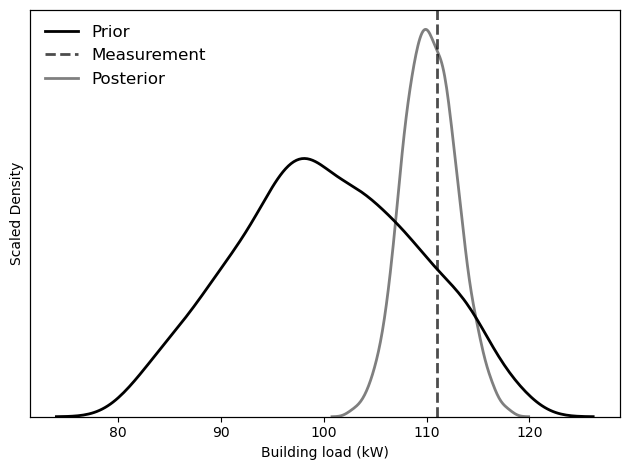

In [31]:
fig, ax = plt.subplots()

prior = sns.kdeplot(thetas,label='Prior',color='k',lw=2)

ymax = ax.get_ylim()[1]*1.5
msr = ax.vlines(z,0,ymax,label='Measurement',color='k', alpha=0.7, ls='--', lw=2)

ax2 = ax.twinx()
post = sns.kdeplot(
    samples,
    #cut=0,
    label='Posterior',
    ax=ax2, c='k', alpha=0.5, lw=2
)

ax.set_ylim(0,ymax)
ax.get_yaxis().set_ticks([])
ax.yaxis.set_label_text('Scaled Density')
ax.xaxis.set_label_text('Building load (kW)')
ax2.get_yaxis().set_ticks([])
ax2.yaxis.set_label_text('')

lns = ax.get_lines() + [msr] + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left', frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('plots','msr_uncertainty_reduction.pdf'), transparent=True)
plt.show()

#### Perform design with reduced uncertainty

In [11]:
tsamples = 50 # no. of samples from prior
vsamples = 10 # no. of samples from posterior
# we only use 10 samples in each SP as this provides a reasonable runtime for our example
# remember, the SP computational cost scales with roughlt the cube of the number of scenarios

# resample for consistency with other notebooks
random.seed(11)
thetas = stats.truncnorm.rvs(-2, 2, loc=v['mean_load'], scale=v['mean_load_std'], size=tsamples)
zs = stats.norm.rvs(loc=thetas, scale=thetas*msr_error)

posterior_results = []

In [12]:
random.seed(11)

for z in tqdm(zs, desc='Solving posterior problems'):
    ## Go get a cuppa, this one will take a while

    # sample from posterior distribution of load corresponding to measurement z
    # we've wrapped this in a function for convenience
    varthetas = sample_posterior(z=z, nsamples=vsamples, msr_error=msr_error)

    # create scenarios by sampling from prior distributions of other uncertainties
    scenarios = {
        'mean_load': varthetas,
        'solar_year': random.choice(solar_years, vsamples),
        'load_year': random.choice(load_years, vsamples),
        'battery_efficiency': stats.truncnorm.rvs(-2, 2, loc=v['battery_efficiency'], scale=v['battery_efficiency_std'], size=vsamples),
        'battery_cost': stats.truncnorm.rvs(-2, 2, loc=v['battery_cost'], scale=v['battery_cost_std'], size=vsamples),
    }

    # optimise design over posterior distribution
    post_results = run_model(
        solar_capacity=None,
        battery_capacity=None,
        **scenarios
    )

    posterior_results.append(post_results)

Solving posterior problems:   0%|          | 0/50 [00:00<?, ?it/s]

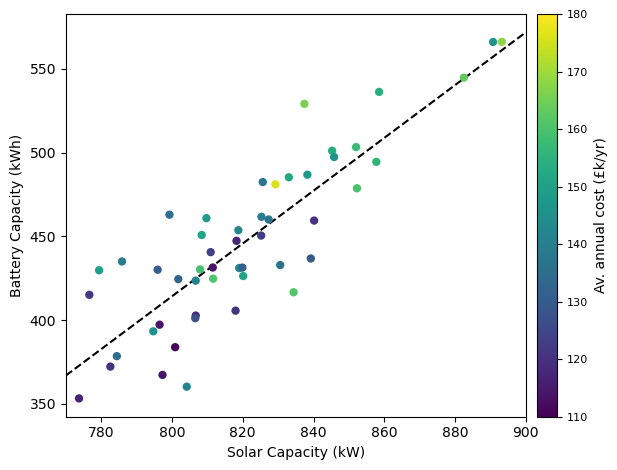

In [13]:
solar_caps = [r['solar_capacity'] for r in posterior_results]
battery_caps = [r['battery_capacity'] for r in posterior_results]
costs = [s['total']/1e3 for s in posterior_results]

reg = linregress(solar_caps,battery_caps)

fig, ax = plt.subplots()

norm = plt.Normalize(round(0.975*min(costs),-1), round(1.025*max(costs),-1))
cmap = cmaps['viridis']

xmin = round(0.99*min(solar_caps),-1)
xmax = round(1.01*max(solar_caps),-1)
reg_xs = np.linspace(xmin, xmax, 100)
ax.plot(reg_xs, reg.slope*reg_xs + reg.intercept, 'k--', alpha=1, label='__nolegend__', zorder=0)

ax.scatter(
    x=solar_caps,
    y=battery_caps,
    c=costs,
    norm=norm,
    cmap=cmap,
    marker='o',
    alpha=1,
    lw=0,
)

cbar = fig.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm), ax=ax, pad=0.02)
cbar.set_label('Av. annual cost (£k/yr)')
cbar.ax.tick_params(labelsize=8)

plt.xlim(xmin, xmax)
plt.xlabel('Solar Capacity (kW)')
plt.ylabel('Battery Capacity (kWh)')

plt.tight_layout()
plt.savefig(os.path.join('plots','posterior_designs.pdf'), transparent=True)
plt.show()